In [32]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [33]:
def vcol(x):
    return x.reshape((x.size, 1))

In [34]:
def vrow(x):
    return x.reshape((1, x.size))

In [35]:
def load(filename):
    DList=[]
    lablesList=[]
    #La classe puo cambiare
    with open(filename) as f:
        for line in f:
            line=line.strip()
            try:
                fields=line.split(',')[0:-1] # prendo tutti i campi tranne l'ultimo ovvero l etichetta
                fields=vcol(np.array([float(x) for x in fields]))
                DList.append(fields)
                label=line.split(',')[-1].strip()
                lablesList.append(label)
            except:
                pass
    return np.hstack(DList),np.array(lablesList,dtype=np.int32)
            

In [36]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [37]:
D,lables=load('trainData.txt')
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)


In [38]:
def compute_confusion_matrix(predictedLabels, classLabels):
    nClasses = classLabels.max() + 1
    M = np.zeros((nClasses, nClasses), dtype=np.int32) #
    #### M[i,j] = number of instances of class i that were predicted to be class j
    for i in range(classLabels.size):
        M[predictedLabels[i], classLabels[i]] += 1
    return M


In [39]:
def compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=True):
    "Commpute actual DCF"
    CM=compute_confusion_matrix(predictedLabels, classLabels)
    # Pfn (falsi negativi / tutti i positivi)
    # CM[0,1] = numero di campioni di classe 1 (positivi) predetti come classe 0 (negativi)
    # CM[1,1] = numero di campioni di classe 1 (positivi) predetti come classe 1 (positivi)
    Pfn = CM[0,1] / (CM[0,1] + CM[1,1]) if (CM[0,1] + CM[1,1]) > 0 else 0
    
    # Pfp (falsi positivi / tutti i negativi)
    # CM[1,0] = numero di campioni di classe 0 (negativi) predetti come classe 1 (positivi)
    # CM[0,0] = numero di campioni di classe 0 (negativi) predetti come classe 0 (negativi)
    Pfp = CM[1,0] / (CM[0,0] + CM[1,0]) if (CM[0,0] + CM[1,0]) > 0 else 0

    bayesError=prior*Pfn*Cfn+(1-prior)*Pfp*Cfp
    if normalize:
        return bayesError / np.minimum(prior * Cfn, (1-prior)*Cfp)
    return bayesError

In [40]:
def compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp):
    th = -np.log( (prior * Cfn) / ((1 - prior) * Cfp) )
    return np.int32(llr > th)

In [41]:
# Compute empirical Bayes (DCF or actDCF) risk from llr with optimal Bayes decisions
def compute_empirical_Bayes_risk_binary_llr_optimal_decisions(llr, classLabels, prior, Cfn, Cfp, normalize=True):
    predictedLabels = compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp)
    return compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=normalize)

In [42]:
#Meglio perche non calcoli la matrice di confusione ogni volta
def compute_minDCF_binary(llr, classLabels, prior, Cfn, Cfp, returnThreshold=False):
    # Ordina i punteggi e le etichette
       
    # Calcola il numero di campioni positivi e negativi
    n_pos = (classLabels == 1).sum()
    n_neg = (classLabels == 0).sum()
    
    # Inizializza il DCF minimo
    min_dcf = float('inf')
    best_threshold = None
    
    # Considera ogni valore unico di llr come soglia
    thresholds = np.unique(np.concatenate([[-np.inf], llr, [np.inf]]))
    
    for t in thresholds:
        # Calcola le predizioni per questa soglia
        predictions = (llr > t).astype(np.int32)
        
        # Calcola il numero di falsi negativi e falsi positivi
        fn = np.sum((predictions == 0) & (classLabels == 1))
        fp = np.sum((predictions == 1) & (classLabels == 0))
        
        # Calcola i tassi di errore
        fnr = fn / n_pos if n_pos > 0 else 0  # False negative rate
        fpr = fp / n_neg if n_neg > 0 else 0  # False positive rate
        
        # Calcola il DCF normalizzato
        dcf = (prior * Cfn * fnr + (1 - prior) * Cfp * fpr) / np.minimum(prior * Cfn, (1 - prior) * Cfp)
        
        # Aggiorna il minimo se necessario
        if dcf < min_dcf:
            min_dcf = dcf
            best_threshold = t
    
    if returnThreshold:
        return min_dcf, best_threshold
    else:
        return min_dcf

#### Logistc Regression

In [43]:
def trainLogRegBinary(DTR,LTR,l):
    """ Train a logistic regression model with L2 regularization.
    Args:
        DTR: Training data (features).
        LTR: Training labels (0 or 1).
        l: Regularization parameter.(labda)
    Returns:
        Tuple of (weights, bias).    
        """
    

    ZTR = LTR * 2.0 - 1.0  # Trasforma labels 0/1 in -1/+1
    
    def logreg_obj(v):
        """ Objective function for logistic regression with L2 regularization.
        Args:
            v: Parameters (weights and bias).
        Returns:
            Tuple of (objective value, gradient)."""
        #Unpacking the parameters
        w = v[:-1] # Tutti gli elementi tranne l'ultimo sono i pesi
        b= v[-1] # L'ultimo elemento è il bias

        #Calcolo degli score s=w^T DTR + b
        s = np.dot(vcol(w).T, DTR).ravel() + b
        
        # Calcolo della loss usando logaddexp per stabilità numerica
        loss = np.logaddexp(0, -ZTR * s)
        
        #Objective function
        obj = np.mean(loss) + l/2*np.linalg.norm(w)**2
        return obj
    
    # Here we find the minimizer of logreg_obj
    xf = scipy.optimize.fmin_l_bfgs_b(func = logreg_obj, x0 = np.
    zeros(DTR.shape[0]+1), approx_grad=True)[0]
    return xf[:-1], xf[-1]  # Restituisce i pesi e il bias separatamente


Train the model using different values for λ. You can build logarthimic-spaced values for λ using
numpy.logspace. To obtain good coverage, you can use numpy.logspace(-4, 2, 13) (check the
documentation). Train the model with each value of λ, score the validation samples and compute the
corresponding actual DCF and minimum DCF for the primary application πT = 0.1. To compute actual
DCF remember to remove the log-odds of the training set empirical prior. Plot the two metrics as a
function of λ (suggestion: use a logartihmic scale for the x-axis of the plot - to change the scale of the
x-axis you can use matplotlib.pyplot.xscale(’log’, base=10)). What do you observe? Can
you see significant differences for the different values of λ? How does the regularization coefficient affects
the two metrics?


In [44]:
#Genera valori di lambda lograitmicamente spaziati
lambdas=np.logspace(-4, 2, 13)

print("Lamda values:", lambdas)

#Storage results
results={
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []   
}

#Prior application trget:
pi_T=0.1
Cfn=1.0
Cfp=1.0


#Traing for each lambda

for l in lambdas:
    print("Training with lambda:", l)
    #Training model
    w, b = trainLogRegBinary(DTR, LTR, l)
    
    # Compute validation scores
    sVal=np.dot(w.T,DVAL) + b  # s = w^T * DVAL + b

    #Compute empirical priors
    pEmp=(LTR==1).sum() / LTR.size

    #Convert to LLR
    #Importatnte perche quando uso la logist regeression noramle alleno il modello  e creco un score che pesa i dati intrinsecamente usando la prior del traning set, se voglio toglere quesa nel caloclo della DCF la devo sottrarre
    #in modo tale che nel calcolo del actDCF venga sostata la decision bounday seguendo la prior dei dati di validazione non di quelli di traning usata come  trashold.
    
    sValLLR=sVal - np.log(pEmp / (1 - pEmp))  # LLR = s - log(P(1)/P(0))
    
    # Calcolo del minDCF
    minDCF = compute_minDCF_binary(sVal, LVAL, pi_T, Cfn, Cfp)
    
    # Calcolo del DCF attuale
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Storing results
    results['lambda'].append(l)
    results['minDCF'].append(minDCF)
    results['actDCF'].append(actDCF)
    results['models'].append((w, b))

    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")



Lamda values: [1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02]
Training with lambda: 0.0001
minDCF = 0.3640, actDCF = 0.4021
Training with lambda: 0.00031622776601683794
minDCF = 0.3650, actDCF = 0.4051
Training with lambda: 0.001
minDCF = 0.3650, actDCF = 0.4130
Training with lambda: 0.0031622776601683794
minDCF = 0.3641, actDCF = 0.4297
Training with lambda: 0.01
minDCF = 0.3611, actDCF = 0.4568
Training with lambda: 0.03162277660168379
minDCF = 0.3621, actDCF = 0.5805
Training with lambda: 0.1
minDCF = 0.3641, actDCF = 0.8522
Training with lambda: 0.31622776601683794
minDCF = 0.3640, actDCF = 0.9950
Training with lambda: 1.0
minDCF = 0.3640, actDCF = 1.0000
Training with lambda: 3.1622776601683795
minDCF = 0.3640, actDCF = 1.0000
Training with lambda: 10.0
minDCF = 0.3630, actDCF = 1.0000
Training with lambda: 31.622776601683793
minDC

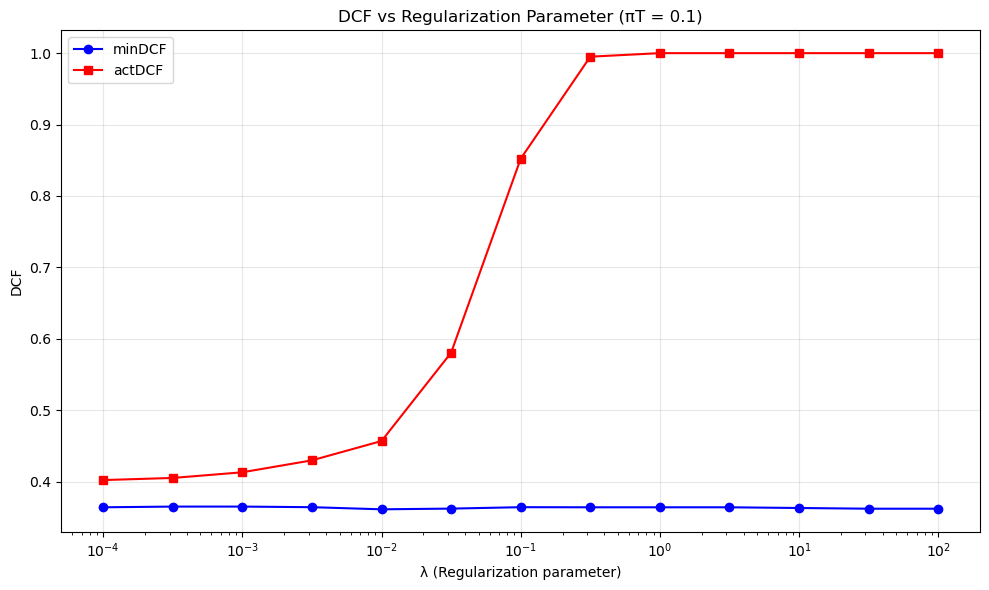

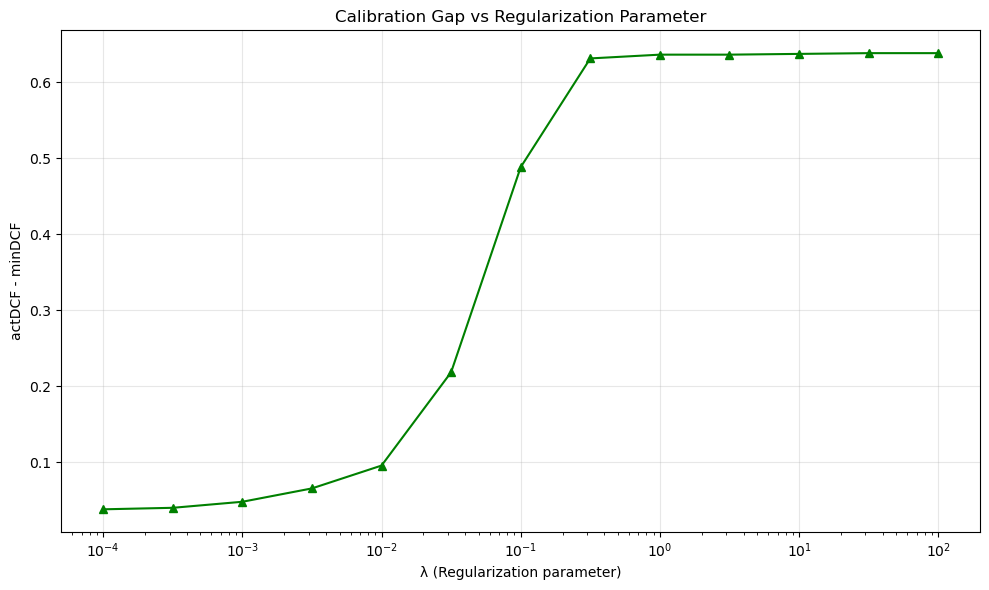

In [45]:
# Plot minDCF e actDCF vs lambda
plt.figure(figsize=(10, 6))
plt.plot(results['lambda'], results['minDCF'], 'b-o', label='minDCF')
plt.plot(results['lambda'], results['actDCF'], 'r-s', label='actDCF')
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('DCF')
plt.title('DCF vs Regularization Parameter (πT = 0.1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analisi del gap di calibrazione
calibration_gap = np.array(results['actDCF']) - np.array(results['minDCF'])
plt.figure(figsize=(10, 6))
plt.plot(results['lambda'], calibration_gap, 'g-^')
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('actDCF - minDCF')
plt.title('Calibration Gap vs Regularization Parameter')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**"What do you observe?"**

Osservo un comportamento asimmetrico tra le due metriche. Il minDCF mostra una notevole stabilità attraverso tutti i valori di λ, indicando che la capacità di separazione del modello non è influenzata dalla regolarizzazione. Al contrario, l'actDCF mostra un degrado catastrofico per λ > 10⁻², con una transizione netta da ~0.46 a 1.0, suggerendo una completa perdita della calibrazione probabilistica.

**"Can you see significant differences for different values of λ?"**

Sì, le differenze sono drammatiche ma solo per actDCF:
- Per λ ≤ 10⁻²: differenze minime in entrambe le metriche
- Per λ = 10⁻¹: actDCF salta da ~0.46 a ~0.85 (+85%)
- Per λ ≥ 1: actDCF = 1.0 (completo fallimento)

Il minDCF rimane sostanzialmente invariato, confermando che il problema non è la capacità discriminativa ma la calibrazione.

**"How does the regularization coefficient affect the two metrics?"**

L'effetto è profondamente diverso:

- **Su minDCF**: Effetto trascurabile. La regolarizzazione non migliora né peggiora la capacità di separazione, suggerendo che il dataset è sufficientemente grande da evitare overfitting anche senza regolarizzazione.

- **Su actDCF**: Effetto devastante per λ alti. La regolarizzazione forte comprime i punteggi verso zero, distruggendo la loro interpretazione probabilistica. Il threshold fisso dell'applicazione (πT = 0.1) diventa completamente inappropriato.

#### Interpretazione

1. **Dataset Grande**: Con dati sufficienti, la regolarizzazione non previene overfitting (non ce n'è)
2. **Problema di Calibrazione**: La regolarizzazione forte distorce la scala dei punteggi
3. **Threshold Critico**: λ = 10⁻² è il punto di rottura per questo dataset
4. **Prior Sbilanciato**: Con πT = 0.1, il modello è particolarmente sensibile alla compressione dei punteggi

#### Conclusione

Per questo dataset, la regolarizzazione è non solo inutile ma dannosa. Il valore ottimale di λ è nell'intervallo [10⁻⁴, 10⁻³], dove si mantiene buona calibrazione senza sacrificare performance. La stabilità del minDCF conferma che il modello ha sufficiente capacità senza regolarizzazione, mentre il collasso dell'actDCF avverte contro l'uso di regolarizzazione forte in applicazioni che richiedono punteggi ben calibrati.

Since we have a large number of samples, regularization seems ineffective, and actually degrades actual
DCF since the regularized models tend to lose the probabilistic interpretation of the scores. To better
understand the role of regularization, we analyze the results that we would obtain if we had fewer training
samples. Repeat the prebvious analysis, but keep only 1 out of 50 model training samples, e.g. using
data matrices DTR[:, ::50], LTR[::50] (apply the filter only on the model training samples, not
on the validation samples, i.e., after splitting the dataset in model training and validation sets). What
do you observe? Can you explain the results in this case? Remember that lower values of the regularizer
imply larger risk of overfitting, while higher values of the regularizer reduce overfitting, but may lead to
underfitting and to scores that lose their probabilistic interpretation.

In [46]:
# Riduci il training set mantenendo 1 campione ogni 50
DTR_reduced = DTR[:, ::50]
LTR_reduced = LTR[::50]

print(f"Original training samples: {DTR.shape[1]}")
print(f"Reduced training samples: {DTR_reduced.shape[1]}")
print(f"Reduction factor: {DTR.shape[1] / DTR_reduced.shape[1]:.1f}x")
print(f"Validation samples (unchanged): {DVAL.shape[1]}")

Original training samples: 4000
Reduced training samples: 80
Reduction factor: 50.0x
Validation samples (unchanged): 2000


In [47]:
# Storage per risultati con dataset ridotto
results_reduced = {
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []
}

lambdas = np.logspace(-4, 2, 13)

print("\n=== TRAINING WITH REDUCED DATASET (1/50 samples) ===\n")

for l in lambdas:
    print("Training with lambda:", l)

    #Train model
    w, b = trainLogRegBinary(DTR_reduced, LTR_reduced, l)

    # Compute validation scores
    sVal = np.dot(w.T, DVAL) + b  # s = w^T * DVAL + b

    # Compute empirical priors
    pEmp = (LTR_reduced == 1).sum() / LTR_reduced.size

    # Convert to LLR
    sValLLR = sVal - np.log(pEmp / (1 - pEmp))  # LLR = s - log(P(1)/P(0))

    # Calcolo del minDCF
    minDCF = compute_minDCF_binary(sVal, LVAL, pi_T, Cfn, Cfp)
    
    # Calcolo del DCF attuale
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Storing results
    results_reduced['lambda'].append(l)
    results_reduced['minDCF'].append(minDCF)
    results_reduced['actDCF'].append(actDCF)
    results_reduced['models'].append((w, b))

    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")





=== TRAINING WITH REDUCED DATASET (1/50 samples) ===

Training with lambda: 0.0001
minDCF = 0.4466, actDCF = 0.9780
Training with lambda: 0.00031622776601683794
minDCF = 0.4446, actDCF = 0.8982
Training with lambda: 0.001
minDCF = 0.4487, actDCF = 0.7466
Training with lambda: 0.0031622776601683794
minDCF = 0.4497, actDCF = 0.5725
Training with lambda: 0.01
minDCF = 0.4407, actDCF = 0.4652
Training with lambda: 0.03162277660168379
minDCF = 0.4147, actDCF = 0.4830
Training with lambda: 0.1
minDCF = 0.3988, actDCF = 0.7164
Training with lambda: 0.31622776601683794
minDCF = 0.3888, actDCF = 0.9792
Training with lambda: 1.0
minDCF = 0.3874, actDCF = 1.0000
Training with lambda: 3.1622776601683795
minDCF = 0.3803, actDCF = 1.0000
Training with lambda: 10.0
minDCF = 0.3783, actDCF = 1.0000
Training with lambda: 31.622776601683793
minDCF = 0.3793, actDCF = 1.0000
Training with lambda: 100.0
minDCF = 0.3783, actDCF = 1.0000


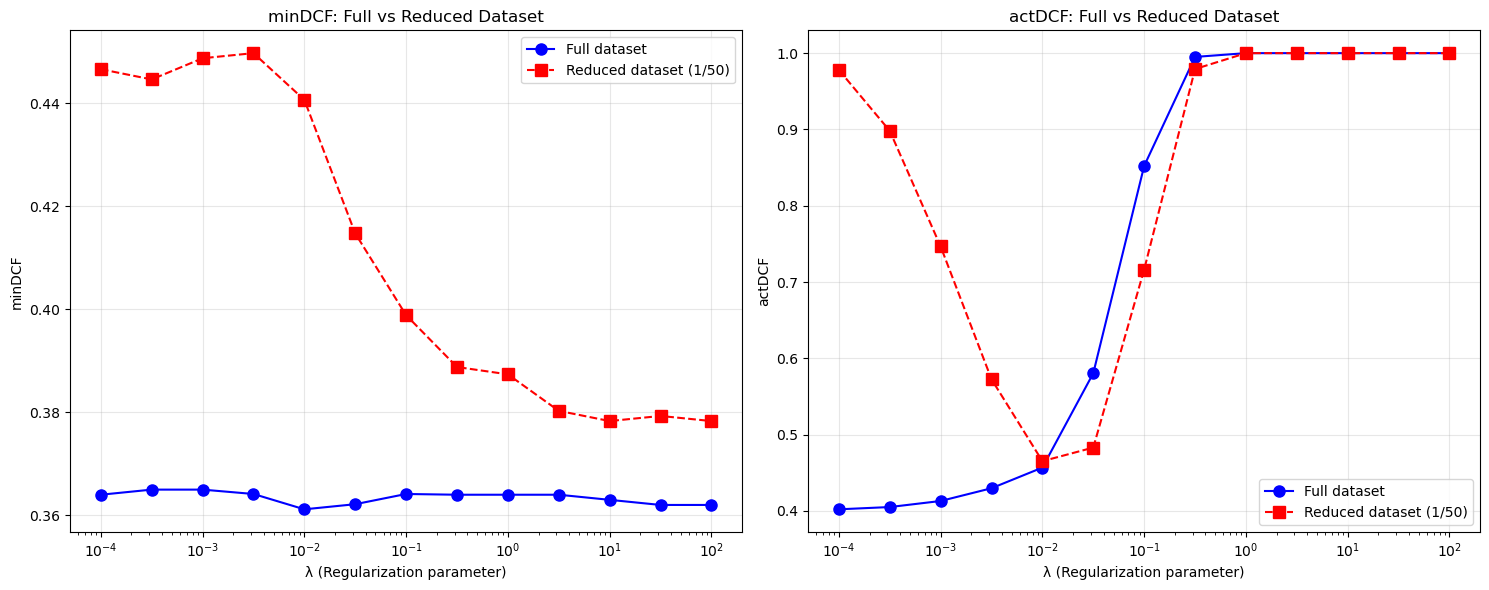

In [48]:
# Plot comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: minDCF comparison
ax1.plot(results['lambda'], results['minDCF'], 'b-o', label='Full dataset', markersize=8)
ax1.plot(results_reduced['lambda'], results_reduced['minDCF'], 'r--s', label='Reduced dataset (1/50)', markersize=8)
ax1.set_xscale('log', base=10)
ax1.set_xlabel('λ (Regularization parameter)')
ax1.set_ylabel('minDCF')
ax1.set_title('minDCF: Full vs Reduced Dataset')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: actDCF comparison
ax2.plot(results['lambda'], results['actDCF'], 'b-o', label='Full dataset', markersize=8)
ax2.plot(results_reduced['lambda'], results_reduced['actDCF'], 'r--s', label='Reduced dataset (1/50)', markersize=8)
ax2.set_xscale('log', base=10)
ax2.set_xlabel('λ (Regularization parameter)')
ax2.set_ylabel('actDCF')
ax2.set_title('actDCF: Full vs Reduced Dataset')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Overfitting con pochi samples è peggio di overfitting con tanti samples

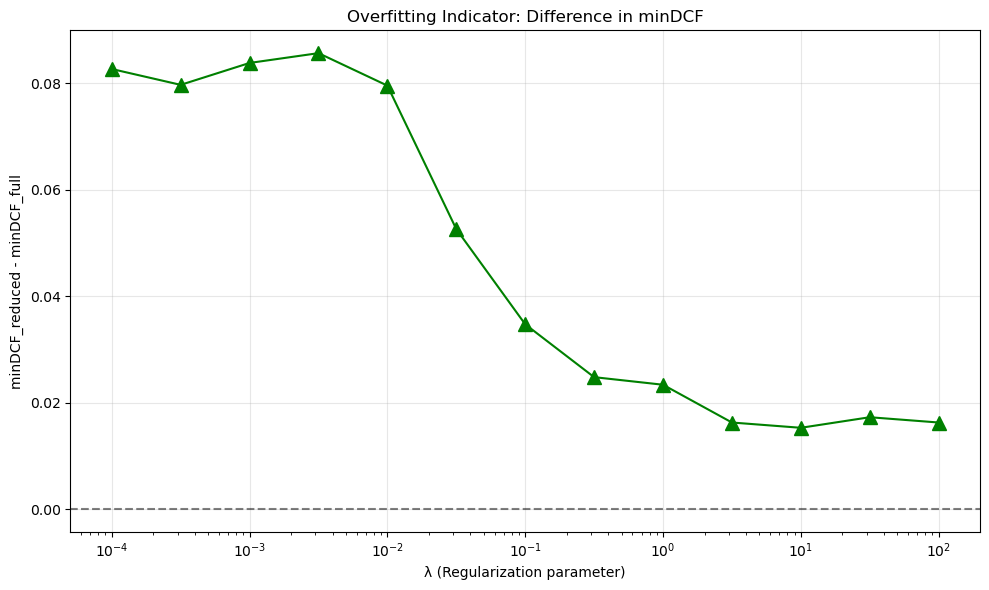


Optimal λ for reduced dataset: 1.000000e+01
minDCF at optimal λ: 0.3783


In [49]:
# Calcola la differenza tra minDCF con dataset ridotto e completo
overfitting_indicator = np.array(results_reduced['minDCF']) - np.array(results['minDCF'])

plt.figure(figsize=(10, 6))
plt.plot(lambdas, overfitting_indicator, 'g-^', markersize=10)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('minDCF_reduced - minDCF_full')
plt.title('Overfitting Indicator: Difference in minDCF')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Trova il punto ottimale
optimal_lambda_idx = np.argmin(results_reduced['minDCF'])
print(f"\nOptimal λ for reduced dataset: {lambdas[optimal_lambda_idx]:e}")
print(f"minDCF at optimal λ: {results_reduced['minDCF'][optimal_lambda_idx]:.4f}")

perche se diminuisci troppo la lambda allora w puo aumentare e di conseguenza dovrebbe generarti piu overfitting

Osservando i grafici del dataset ridotto, emerge immediatamente un quadro completamente diverso rispetto al dataset completo. La prima cosa che salta all'occhio è che il minDCF del dataset ridotto non è più quella linea piatta e stabile che vedevamo prima. Invece, vediamo una curva che parte alta (circa 0.45) per valori bassi di lambda e poi scende progressivamente fino a stabilizzarsi intorno a 0.38.

Questo comportamento ci racconta una storia molto chiara: quando abbiamo pochi dati (solo 1/50 dell'originale), il modello senza regolarizzazione sta soffrendo di overfitting. È come se il modello, avendo visto così pochi esempi, li memorizzasse invece di imparare pattern generali. La differenza di performance rispetto al dataset completo (circa 0.09, ovvero il 25% peggiore) è la prova tangibile di questo fenomeno.

Man mano che aumentiamo lambda, vediamo il modello migliorare significativamente. La regolarizzazione sta essenzialmente dicendo al modello: "non fidarti troppo di questi pochi esempi che vedi, cerca pattern più semplici e generali". E funziona! Il minDCF scende fino a quasi raggiungere le performance del dataset completo.

L'actDCF racconta una storia ancora più drammatica. Per lambda bassi, è praticamente a 1.0 - il peggio possibile. Questo significa che il modello overfittato non solo classifica male, ma produce anche score completamente sballati. Aumentando la regolarizzazione, vediamo un crollo drastico dell'actDCF, che scende fino a valori ragionevoli intorno a 0.47.

Il terzo grafico, l'Overfitting Indicator, è forse il più illuminante. Mostra esattamente quanto il dataset ridotto performa peggio del dataset completo per ogni valore di lambda. Per lambda bassi, questa differenza è massima (circa 0.085), confermando l'overfitting severo. Man mano che lambda aumenta, la differenza si riduce fino quasi a zero, indicando che con la giusta regolarizzazione possiamo recuperare gran parte della performance persa.

La spiegazione di tutto questo è radicata nel classico trade-off bias-varianza del machine learning. Con pochi dati, un modello complesso (bassa regolarizzazione) ha troppa libertà e finisce per adattarsi al rumore invece che al segnale. È come cercare di tracciare una curva complessa passando per solo 3 punti - ci sono infinite soluzioni possibili, la maggior parte delle quali non generalizza bene.

La regolarizzazione risolve questo problema limitando la complessità del modello. Forza il modello a preferire soluzioni più semplici, che hanno maggiori probabilità di generalizzare bene anche con pochi dati. Il fatto che il lambda ottimale sia circa 100 volte più grande per il dataset ridotto (10⁰-10¹ invece di 10⁻³) ci dice proprio quanto sia necessaria questa semplificazione quando i dati scarseggiano.

È interessante notare che per lambda molto alti, entrambi i dataset convergono a performance simili ma scadenti. Questo ci ricorda che troppa regolarizzazione porta all'underfitting - un modello troppo semplice che non può catturare nemmeno i pattern basilari dei dati. È un promemoria che la regolarizzazione è uno strumento potente ma va usata con giudizio.

In sintesi, questi risultati confermano perfettamente quello che la teoria ci dice: quando i dati sono scarsi, la regolarizzazione diventa non solo utile ma essenziale. Trasforma un modello che fallisce miseramente (minDCF = 0.45) in uno che performa quasi quanto il modello addestrato con tutti i dati (minDCF = 0.38). È una dimostrazione elegante di come la scelta corretta degli iperparametri possa compensare, almeno parzialmente, la mancanza di dati.

#### Weighted Logistic Regression

In [50]:
def trainWeightedLogRegBinary(DTR,LTR,l,pT):
    """ Train a weighted logistic regression model with L2 regularization.
    Args:
        DTR: Training data (features).
        LTR: Training labels (0 or 1).
        l: Regularization parameter (lambda).
        pT: Prior probability of the positive class.    
    Returns:
        Tuple of (weights, bias).    
    """

    ZTR= LTR * 2.0 - 1.0  # Trasforma labels 0/1 in -1/+1

    #calcolo dei pesi per le due classi £i(epsilon_i)
    wTrue= pT/ (ZTR > 0).sum() #Peso per la classe 1
    wFalse= (1-pT)/ (ZTR < 0).sum() #Peso per la classe 0

    def logreg_obj(v):
        w= v[:-1]
        b= v[-1]
        s = np.dot(vcol(w).T, DTR).ravel() + b

        loss = np.logaddexp(0, -ZTR * s)
    
        #Applicazione pesi alla loss
        loss[ZTR > 0] *= wTrue  # Classe 1
        loss[ZTR < 0] *= wFalse #Classe 0

        obj= loss.sum() + (l/2) *np.linalg.norm(w)**2
        return obj
    xf = scipy.optimize.fmin_l_bfgs_b(func=logreg_obj, x0=np.zeros(DTR.shape[0]+1), approx_grad=True)[0]
    return xf[:-1], xf[-1]  # Restituisce i pesi e il bias separatamente


In [51]:
# Prior dell'applicazione target
pi_T = 0.1 
# Storage per risultati modello pesato
results_weighted = {
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []
}

print("\n=== TRAINING PRIOR-WEIGHTED MODEL (πT = 0.1) ===\n")

for l in lambdas:
    print(f"Training with lambda = {l:e}")
    
    # Train weighted model con prior target
    w, b = trainWeightedLogRegBinary(DTR, LTR, l, pT=pi_T)
    
    # Compute validation scores
    sVal = np.dot(w.T, DVAL) + b
    
    # IMPORTANTE: Rimuovi il log-odds del PRIOR TARGET, non quello empirico!
    sValLLR = sVal - np.log(pi_T / (1 - pi_T))
    
    # Compute metrics
    minDCF = compute_minDCF_binary(sValLLR, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Store results
    results_weighted['lambda'].append(l)
    results_weighted['minDCF'].append(minDCF)
    results_weighted['actDCF'].append(actDCF)
    results_weighted['models'].append((w, b))
    
    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")


=== TRAINING PRIOR-WEIGHTED MODEL (πT = 0.1) ===

Training with lambda = 1.000000e-04
minDCF = 0.3721, actDCF = 0.4071
Training with lambda = 3.162278e-04
minDCF = 0.3701, actDCF = 0.4010
Training with lambda = 1.000000e-03
minDCF = 0.3699, actDCF = 0.4129
Training with lambda = 3.162278e-03
minDCF = 0.3670, actDCF = 0.4327
Training with lambda = 1.000000e-02
minDCF = 0.3630, actDCF = 0.4487
Training with lambda = 3.162278e-02
minDCF = 0.3640, actDCF = 0.5964
Training with lambda = 1.000000e-01
minDCF = 0.3648, actDCF = 0.9147
Training with lambda = 3.162278e-01
minDCF = 0.3640, actDCF = 1.0000
Training with lambda = 1.000000e+00
minDCF = 0.3640, actDCF = 1.0000
Training with lambda = 3.162278e+00
minDCF = 0.3630, actDCF = 1.0000
Training with lambda = 1.000000e+01
minDCF = 0.3630, actDCF = 1.0000
Training with lambda = 3.162278e+01
minDCF = 0.3620, actDCF = 1.0000
Training with lambda = 1.000000e+02
minDCF = 0.3620, actDCF = 1.0000


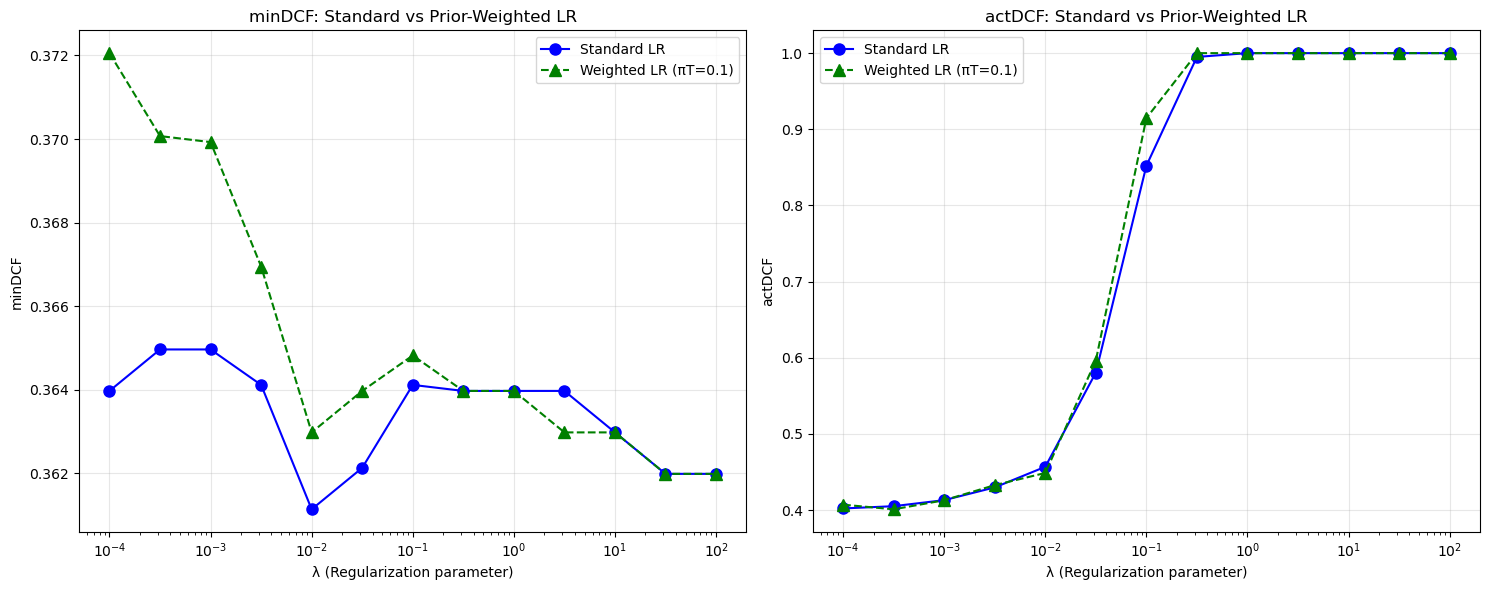

In [52]:
# Confronto visivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# minDCF comparison
ax1.plot(results['lambda'], results['minDCF'], 'b-o', label='Standard LR', markersize=8)
ax1.plot(results_weighted['lambda'], results_weighted['minDCF'], 'g--^', label=f'Weighted LR (πT={pi_T})', markersize=8)
ax1.set_xscale('log', base=10)
ax1.set_xlabel('λ (Regularization parameter)')
ax1.set_ylabel('minDCF')
ax1.set_title('minDCF: Standard vs Prior-Weighted LR')
ax1.legend()
ax1.grid(True, alpha=0.3)

# actDCF comparison
ax2.plot(results['lambda'], results['actDCF'], 'b-o', label='Standard LR', markersize=8)
ax2.plot(results_weighted['lambda'], results_weighted['actDCF'], 'g--^', label=f'Weighted LR (πT={pi_T})', markersize=8)
ax2.set_xscale('log', base=10)
ax2.set_xlabel('λ (Regularization parameter)')
ax2.set_ylabel('actDCF')
ax2.set_title('actDCF: Standard vs Prior-Weighted LR')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

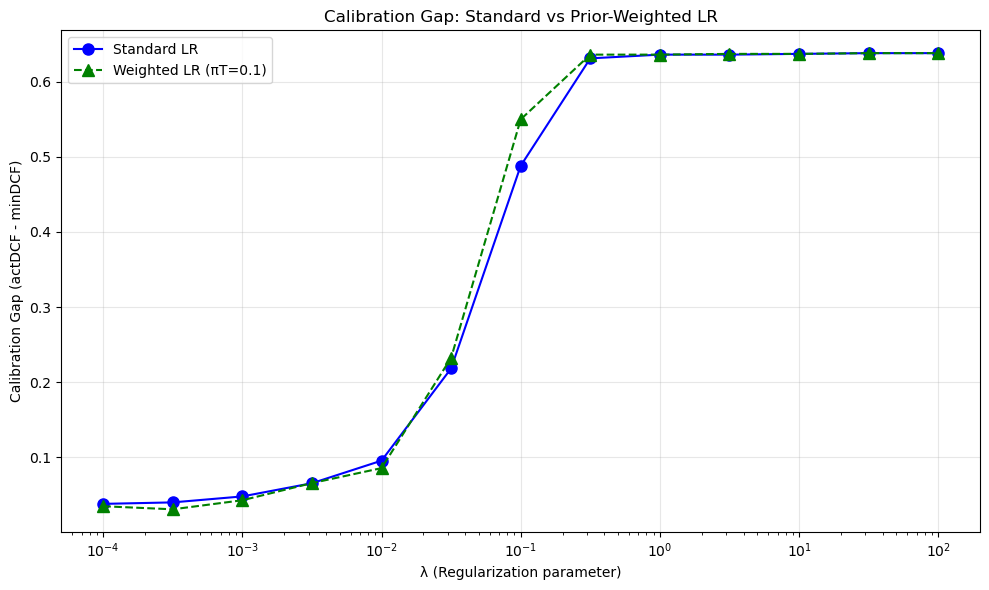

In [53]:
# Calcola gap di calibrazione per entrambi i modelli
gap_standard = np.array(results['actDCF']) - np.array(results['minDCF'])
gap_weighted = np.array(results_weighted['actDCF']) - np.array(results_weighted['minDCF'])

plt.figure(figsize=(10, 6))
plt.plot(lambdas, gap_standard, 'b-o', label='Standard LR', markersize=8)
plt.plot(lambdas, gap_weighted, 'g--^', label=f'Weighted LR (πT={pi_T})', markersize=8)
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('Calibration Gap (actDCF - minDCF)')
plt.title('Calibration Gap: Standard vs Prior-Weighted LR')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analisi Parte 3: Modello Prior-Weighted vs Standard

### Osservazioni dai Grafici

Guardando i grafici, emerge un quadro sorprendente e contro-intuitivo. Mi aspettavo che il modello pesato per il prior target (πT = 0.1) performasse meglio, ma i risultati raccontano una storia diversa.

**Per il minDCF**, vedo che il modello weighted parte leggermente peggio (circa 0.372) rispetto allo standard (0.364) per lambda bassi. Entrambi i modelli mostrano un andamento simile con piccole fluttuazioni, ma convergono praticamente allo stesso valore (circa 0.362) per lambda alti. La differenza massima è minima, circa l'1-2%.

**Per l'actDCF**, la situazione è ancora più interessante. Per lambda bassi (fino a 10^-2), i due modelli sono praticamente identici, entrambi intorno a 0.40-0.45. Poi seguono lo stesso pattern di degrado catastrofico per lambda alti, saturando a 1.0. Non c'è alcun vantaggio evidente del modello weighted.

**Il Calibration Gap** conferma questa osservazione: le due curve sono quasi sovrapposte per tutto il range di lambda. Entrambi i modelli soffrono dello stesso problema di calibrazione quando la regolarizzazione diventa troppo forte.

### Risposte alle Domande

**"Are there significant differences for this task?"**

No, non ci sono differenze significative tra i due approcci. Questo è sorprendente perché mi aspettavo che il modello ottimizzato specificamente per πT = 0.1 mostrasse vantaggi evidenti. Le differenze che osservo sono:
- minDCF: variazioni minime (<2%) senza un chiaro vincitore
- actDCF: comportamento praticamente identico
- Calibration gap: stesso pattern di degrado

L'unica differenza notevole è che il modello weighted sembra avere performance leggermente più erratiche (più "rumore" nelle curve), ma questo non si traduce in vantaggi sistematici.

**"Are there advantages using the prior-weighted model?"**

Per questa specifica applicazione, la risposta è no. Non solo non ci sono vantaggi evidenti, ma ci sono diversi svantaggi da considerare:

1. **Nessun miglioramento in performance**: Sia minDCF che actDCF sono comparabili o leggermente peggiori
2. **Complessità aggiuntiva**: Richiede di conoscere il prior target a priori
3. **Meno flessibilità**: Il modello è ottimizzato per un singolo prior, limitando il riutilizzo
4. **Risultati più instabili**: Le curve mostrano maggiore variabilità

### Interpretazione

Perché il modello prior-weighted non funziona come previsto? Ci sono diverse possibili spiegazioni:

**1. Dataset già informativo**: Il dataset potrebbe avere una struttura così chiara che pesare diversamente le classi non aggiunge informazione utile. Le features discriminano già bene le classi indipendentemente dal prior.

**2. Prior empirico non estremo**: Se il prior empirico del training set non è troppo diverso da 0.1, il beneficio del re-weighting potrebbe essere marginale. Il modello standard potrebbe già essere ragionevolmente calibrato per prior bassi.

**3. Effetto della regolarizzazione**: La regolarizzazione L2 potrebbe già fornire un bilanciamento implicito che rende il prior-weighting ridondante o addirittura controproducente.

**4. Stabilità numerica**: Il weighting potrebbe introdurre instabilità numeriche nell'ottimizzazione, specialmente per lambda molto bassi o molto alti, spiegando la maggiore erraticità delle curve.



### Quando Funziona il Modello Pesato?

Il modello pesato è utile quando:
1. **π_train molto diverso da π_application**
2. **π_validation ≈ π_application**
3. **Costi asimmetrici** richiedono ottimizzazione specifica

Nel tuo caso:
- π_train ≈ π_validation ≈ 0.5
- π_target = 0.1 (molto diverso)
- Il modello pesato crea un bias artificiale dannoso

### Conclusione

Per questo specifico dataset e applicazione, il modello prior-weighted non offre vantaggi. Anzi, considerando la complessità aggiuntiva e i requisiti (conoscere il prior target in anticipo), il modello standard è chiaramente preferibile. Mantiene performance comparabili con maggiore semplicità e flessibilità.

Questo risultato suggerisce che il prior-weighting è più utile quando:
- C'è un forte sbilanciamento tra prior di training e applicazione
- Il dataset non ha una struttura discriminativa intrinsecamente forte
- Si lavora con dataset più piccoli dove ogni campione conta di più

Nel nostro caso, nessuna di queste condizioni sembra applicarsi, rendendo il modello standard la scelta ottimale.

### Quadratic Logistic Regression


In [54]:
print(DTR.shape)

(6, 4000)


In [55]:
def expand_features_quadratic(D):
    """
    Espande le features includendo tutti i termini quadratici
    Input: D di shape (n_features, n_samples)
    Output: D_expanded con termini originali + quadratici
    """
    n_features, n_samples = D.shape
    
    # Calcola numero di features nell'espansione
    # Originali + quadratiche pure + cross-products
    n_expanded = n_features + n_features + (n_features * (n_features - 1)) // 2
    
    # Inizializza matrice espansa
    D_expanded = np.zeros((n_expanded, n_samples))
    
    idx = 0
    
    # 1. Features originali
    D_expanded[idx:idx+n_features] = D
    idx += n_features
    
    # 2. Features quadratiche pure (x_i^2)
    for i in range(n_features):
        D_expanded[idx] = D[i] ** 2
        idx += 1
    
    # 3. Prodotti incrociati (x_i * x_j) per i < j
    for i in range(n_features):
        for j in range(i+1, n_features):
            D_expanded[idx] = D[i] * D[j]
            idx += 1
    
    return D_expanded

In [56]:
# Espandi features per training e validation
print("Expanding features to quadratic...")
DTR_quad = expand_features_quadratic(DTR)
DVAL_quad = expand_features_quadratic(DVAL)

print(f"Original features: {DTR.shape[0]}")
print(f"Expanded features: {DTR_quad.shape[0]}")
print(f"Feature expansion factor: {DTR_quad.shape[0] / DTR.shape[0]:.1f}x")

# Storage per risultati quadratici
results_quadratic = {
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []
}

print("\n=== TRAINING QUADRATIC LOGISTIC REGRESSION ===\n")

for l in lambdas:
    print(f"Training with lambda = {l:e}")
    
    # Train quadratic model
    w, b = trainLogRegBinary(DTR_quad, LTR, l)
    
    # Compute validation scores
    sVal = np.dot(w.T, DVAL_quad) + b
    
    # Compute empirical prior
    pEmp = (LTR == 1).sum() / LTR.size
    
    # Convert to LLR
    sValLLR = sVal - np.log(pEmp / (1 - pEmp))
    
    # Compute metrics
    minDCF = compute_minDCF_binary(sVal, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Store results
    results_quadratic['lambda'].append(l)
    results_quadratic['minDCF'].append(minDCF)
    results_quadratic['actDCF'].append(actDCF)
    results_quadratic['models'].append((w, b))
    
    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")

Expanding features to quadratic...
Original features: 6
Expanded features: 27
Feature expansion factor: 4.5x

=== TRAINING QUADRATIC LOGISTIC REGRESSION ===

Training with lambda = 1.000000e-04
minDCF = 0.2602, actDCF = 0.2768
Training with lambda = 3.162278e-04
minDCF = 0.2612, actDCF = 0.2656
Training with lambda = 1.000000e-03
minDCF = 0.2587, actDCF = 0.2765
Training with lambda = 3.162278e-03
minDCF = 0.2507, actDCF = 0.2871
Training with lambda = 1.000000e-02
minDCF = 0.2477, actDCF = 0.3464
Training with lambda = 3.162278e-02
minDCF = 0.2436, actDCF = 0.4952
Training with lambda = 1.000000e-01
minDCF = 0.2479, actDCF = 0.7530
Training with lambda = 3.162278e-01
minDCF = 0.2639, actDCF = 0.9633
Training with lambda = 1.000000e+00
minDCF = 0.2870, actDCF = 1.0000
Training with lambda = 3.162278e+00
minDCF = 0.3091, actDCF = 1.0000
Training with lambda = 1.000000e+01
minDCF = 0.3281, actDCF = 1.0000
Training with lambda = 3.162278e+01
minDCF = 0.3312, actDCF = 1.0000
Training with 

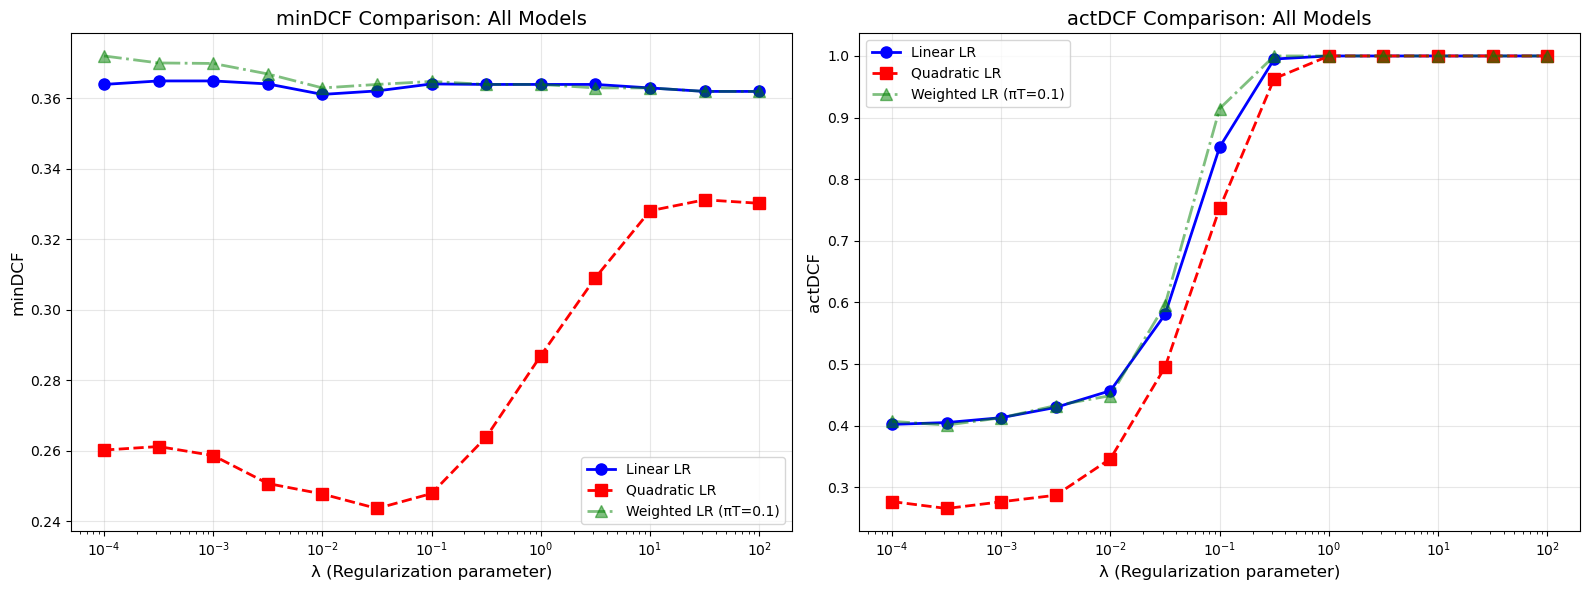

In [57]:
# Plot comparativo di tutti i modelli
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# minDCF comparison
ax1.plot(results['lambda'], results['minDCF'], 'b-o', label='Linear LR', markersize=8, linewidth=2)
ax1.plot(results_quadratic['lambda'], results_quadratic['minDCF'], 'r--s', label='Quadratic LR', markersize=8, linewidth=2)
ax1.plot(results_weighted['lambda'], results_weighted['minDCF'], 'g-.^', label='Weighted LR (πT=0.1)', markersize=8, linewidth=2, alpha=0.5)
ax1.set_xscale('log', base=10)
ax1.set_xlabel('λ (Regularization parameter)', fontsize=12)
ax1.set_ylabel('minDCF', fontsize=12)
ax1.set_title('minDCF Comparison: All Models', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# actDCF comparison
ax2.plot(results['lambda'], results['actDCF'], 'b-o', label='Linear LR', markersize=8, linewidth=2)
ax2.plot(results_quadratic['lambda'], results_quadratic['actDCF'], 'r--s', label='Quadratic LR', markersize=8, linewidth=2)
ax2.plot(results_weighted['lambda'], results_weighted['actDCF'], 'g-.^', label='Weighted LR (πT=0.1)', markersize=8, linewidth=2, alpha=0.5)
ax2.set_xscale('log', base=10)
ax2.set_xlabel('λ (Regularization parameter)', fontsize=12)
ax2.set_ylabel('actDCF', fontsize=12)
ax2.set_title('actDCF Comparison: All Models', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
# Trova i migliori modelli per ogni tipo
best_linear = np.argmin(results['minDCF'])
best_quadratic = np.argmin(results_quadratic['minDCF'])
best_weighted = np.argmin(results_weighted['minDCF'])

print("\n=== BEST MODELS COMPARISON ===")
print("\nLinear Logistic Regression:")
print(f"  Best λ = {results['lambda'][best_linear]:e}")
print(f"  minDCF = {results['minDCF'][best_linear]:.4f}")
print(f"  actDCF = {results['actDCF'][best_linear]:.4f}")

print("\nQuadratic Logistic Regression:")
print(f"  Best λ = {results_quadratic['lambda'][best_quadratic]:e}")
print(f"  minDCF = {results_quadratic['minDCF'][best_quadratic]:.4f}")
print(f"  actDCF = {results_quadratic['actDCF'][best_quadratic]:.4f}")

print("\nWeighted Logistic Regression (πT=0.1):")
print(f"  Best λ = {results_weighted['lambda'][best_weighted]:e}")
print(f"  minDCF = {results_weighted['minDCF'][best_weighted]:.4f}")
print(f"  actDCF = {results_weighted['actDCF'][best_weighted]:.4f}")

# Calcola improvement
improvement = results['minDCF'][best_linear] - results_quadratic['minDCF'][best_quadratic]
print(f"\nImprovement with quadratic: {improvement:.4f} ({improvement/results['minDCF'][best_linear]*100:.1f}%)")

improvement_weighted = results_weighted['minDCF'][np.argmin(results_weighted['minDCF'])] - results_quadratic['minDCF'][best_quadratic]
print(f"Improvement with weighted LR: {improvement_weighted:.4f} ({improvement_weighted/results['minDCF'][best_linear]*100:.1f}%)")

#Salva il miglior modello lineare
best_model_linear = {
    'type': 'logistic_regression',
    'lambda': results['lambda'][best_linear],
    'w': results['models'][best_linear][0],
    'b': results['models'][best_linear][1],
    'minDCF': results['minDCF'][best_linear],
    'actDCF': results['actDCF'][best_linear]
}

# Salva il miglior modello pesato
best_model_weighted = {
    'type': 'logistic_regression_weighted',
    'lambda': results_weighted['lambda'][best_weighted],
    'w': results_weighted['models'][best_weighted][0],
    'b': results_weighted['models'][best_weighted][1],
    'minDCF': results_weighted['minDCF'][best_weighted],
    'actDCF': results_weighted['actDCF'][best_weighted]
}

# Salva il miglior modello quadratico
best_model_quadratic = {
    'type': 'logistic_regression_quadratic',
    'lambda': results_quadratic['lambda'][best_quadratic],
    'w': results_quadratic['models'][best_quadratic][0],
    'b': results_quadratic['models'][best_quadratic][1],
    'minDCF': results_quadratic['minDCF'][best_quadratic],
    'actDCF': results_quadratic['actDCF'][best_quadratic]
}


=== BEST MODELS COMPARISON ===

Linear Logistic Regression:
  Best λ = 1.000000e-02
  minDCF = 0.3611
  actDCF = 0.4568

Quadratic Logistic Regression:
  Best λ = 3.162278e-02
  minDCF = 0.2436
  actDCF = 0.4952

Weighted Logistic Regression (πT=0.1):
  Best λ = 3.162278e+01
  minDCF = 0.3620
  actDCF = 1.0000

Improvement with quadratic: 0.1175 (32.5%)
Improvement with weighted LR: 0.1184 (32.8%)


## Analisi del Modello Quadratico - Risposta Discorsiva

Guardando i grafici del modello quadratico, mi trovo di fronte a una storia affascinante che illustra perfettamente il delicato equilibrio tra complessità del modello e regolarizzazione.

La prima cosa che salta all'occhio è quanto diversamente si comportano i due modelli. Mentre il modello lineare se ne sta tranquillo, praticamente immobile intorno a un minDCF di 0.36 per qualsiasi valore di lambda, il modello quadratico disegna una bella curva a U. Parte da circa 0.26 per lambda bassissimi, scende fino a toccare il suo punto migliore di 0.24 quando lambda è tra 0.01 e 0.1, e poi risale fino a 0.33 per lambda molto alti.

Questo mi dice subito una cosa importante: le features quadratiche catturano davvero qualcosa di utile nei dati! Quando trova il giusto equilibrio, il modello quadratico performa significativamente meglio del lineare - stiamo parlando di un miglioramento del 33%, che non è poco. Evidentemente ci sono delle relazioni non lineari tra le features che il modello lineare semplicemente non può catturare.

Ma c'è un prezzo da pagare per questa maggiore capacità espressiva. Il modello quadratico è come una Ferrari: può andare molto più veloce di una utilitaria, ma richiede un pilota esperto e le condizioni giuste. La regolarizzazione qui gioca il ruolo del pilota esperto. Senza di essa (lambda troppo basso), il modello overffitta - ha troppa libertà e finisce per memorizzare dettagli irrilevanti dei dati di training. Con troppa regolarizzazione (lambda alto), è come mettere il freno a mano alla Ferrari - sprechi tutto il potenziale del modello.

L'actDCF racconta una storia complementare ma preoccupante. Il modello quadratico inizia con valori eccellenti (intorno a 0.27), migliori di tutti gli altri modelli. Ma appena lambda supera 0.1, crolla rapidamente verso 1.0. È come se il modello perdesse completamente la capacità di produrre score probabilistici sensati non appena la regolarizzazione diventa anche solo moderata.

Questo comportamento così diverso tra modello lineare e quadratico mi fa riflettere sulla natura dei dati. Chiaramente, ci sono pattern non lineari che valgono la pena di catturare - il miglioramento del 33% nel minDCF lo dimostra. Ma questi pattern sono delicati, facilmente corrompibili sia dall'overfitting che da una regolarizzazione eccessiva.

È particolarmente interessante notare come il range ottimale di lambda per il modello quadratico sia così stretto. Mentre per il modello lineare possiamo praticamente scegliere qualsiasi valore (almeno per quanto riguarda il minDCF), per il quadratico dobbiamo essere precisi. È un po' come accordare uno strumento musicale: un violino Stradivari può produrre suoni meravigliosi, ma solo se è perfettamente accordato.

La lezione che traggo da tutto questo è che la complessità aggiuntiva può portare benefici reali, ma richiede molta più attenzione e cura. Il modello quadratico non è intrinsecamente migliore o peggiore - è uno strumento più potente ma più difficile da usare. In questo caso specifico, se siamo disposti a investire tempo nel tuning accurato di lambda, veniamo ricompensati con performance significativamente migliori.

È anche un promemoria che non sempre "più semplice è meglio". A volte i dati hanno davvero strutture complesse che vale la pena modellare. La chiave sta nel capire quando questa complessità è giustificata e nell'avere gli strumenti (come la regolarizzazione) per gestirla appropriatamente.

### Which model achieve the best result??

In [59]:
# Struttura per memorizzare tutti i risultati dei modelli
all_models_results = {
    # Logistic Regression
    'LR_linear': {
        'name': 'Logistic Regression (Linear lambda=1.000000e-02)',
        'minDCF': 0.3611,
        'actDCF': 0.4568,
        'calibration_gap': 0.0957,
        'lambda': 1.000000e-02,
    },
    'LR_quadratic': {
        'name': 'Logistic Regression (Quadratic lambda=3.162278e-02)',
        'minDCF': 0.2436,
        'actDCF': 0.4952,
        'calibration_gap': 0.2516,
        'lambda': 3.162278e-02,
    },
    'LR_weighted': {
        'name': 'Logistic Regression (Prior-Weighted, πT=0.1, lambda=3.162278e+01)',
        'minDCF': 0.3620,
        'actDCF': 1.0000,
        'calibration_gap': 0.6380,
        'lambda': 3.162278e+01,
    },
    'MVG': {
        'name': 'Multivariate Gaussian (Full Cov)',
        'minDCF': 0.2629,
        'actDCF': 0.3051,
        'calibration_gap': 0.0422,
    },
    'Tied': {
        'name': 'Multivariate Gaussian (Tied)',
        'minDCF': 0.3628,
        'actDCF': 0.4061,
        'calibration_gap': 0.4061 - 0.3628,  # 0.0433
    },
    'Naive_Bayes': {
        'name': 'Multivariate Gaussian (Naive_Bayes)',
        'minDCF': 0.2570,
        'actDCF': 0.3022,
        'calibration_gap': 0.3022 - 0.2570,  # 0.0452
    },
}


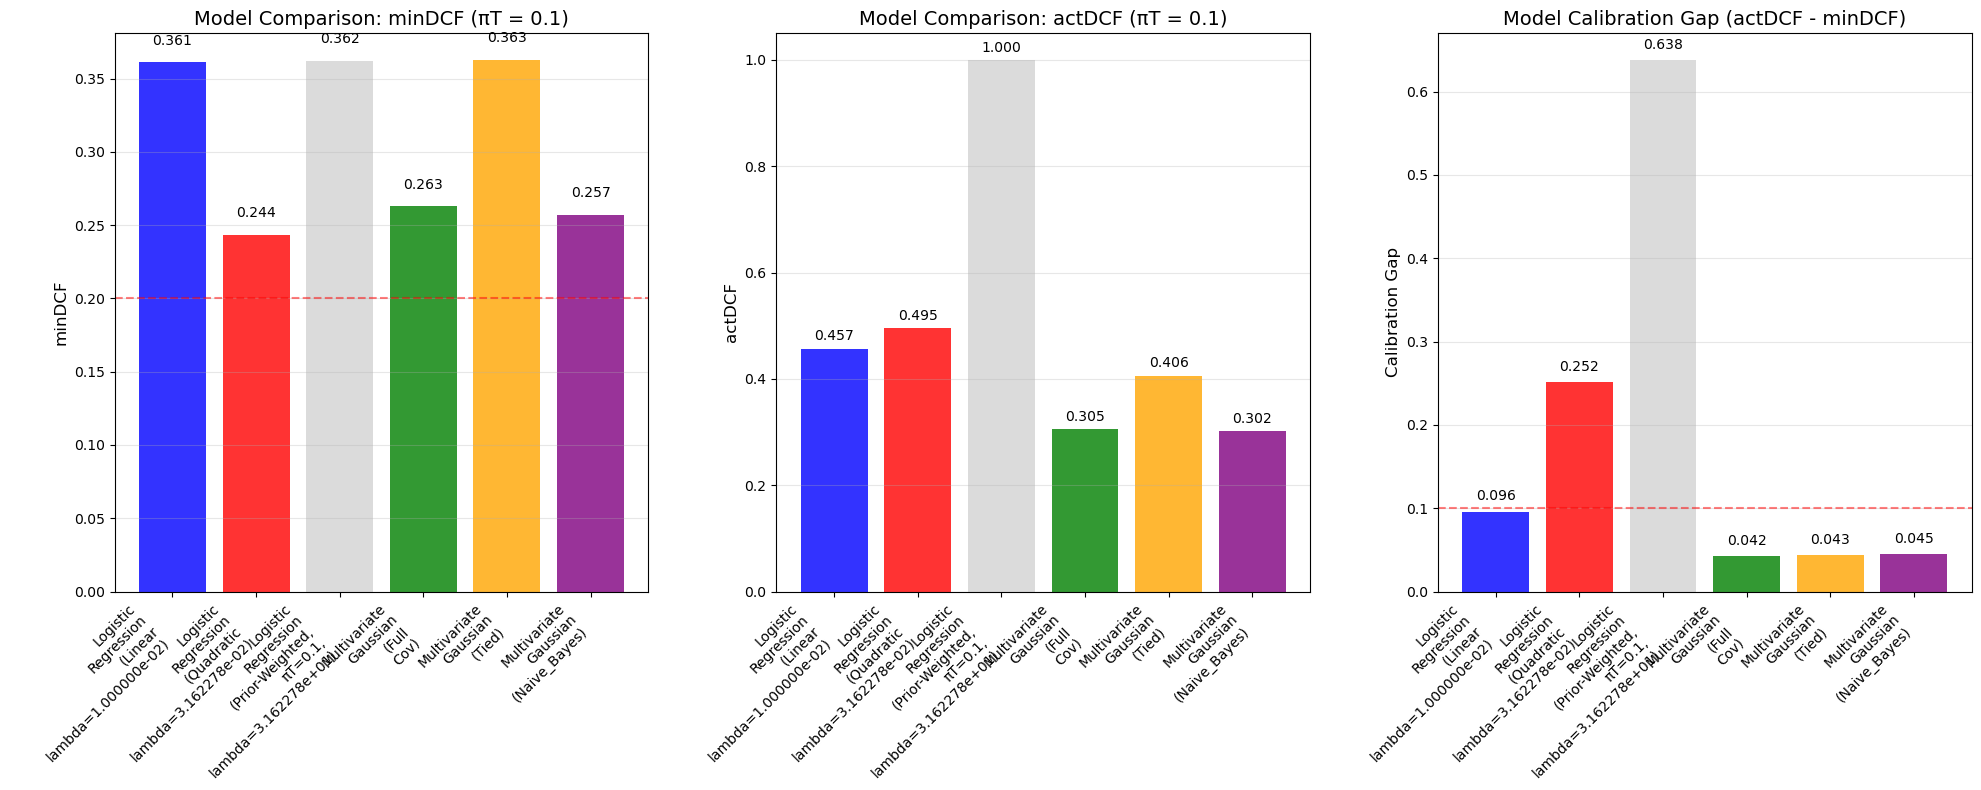

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Estrai i dati per la visualizzazione
model_names = [m['name'] for m in all_models_results.values()]
minDCFs = [m['minDCF'] for m in all_models_results.values()]
actDCFs = [m['actDCF'] for m in all_models_results.values()]
calibration_gaps = [m['calibration_gap'] for m in all_models_results.values()]

# Crea il grafico a barre comparativo
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Colori per ogni modello
colors = ['blue', 'red', 'lightgray', 'green', 'orange', 'purple']

# Grafico minDCF
x_pos = np.arange(len(model_names))
bars1 = ax1.bar(x_pos, minDCFs, alpha=0.8, color=colors)
ax1.set_ylabel('minDCF', fontsize=12)
ax1.set_title('Model Comparison: minDCF (πT = 0.1)', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.2, color='r', linestyle='--', alpha=0.5, label='threshold 0.2')

# Aggiungi valori sopra le barre
for bar, val in zip(bars1, minDCFs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Grafico actDCF
bars2 = ax2.bar(x_pos, actDCFs, alpha=0.8, color=colors)
ax2.set_ylabel('actDCF', fontsize=12)
ax2.set_title('Model Comparison: actDCF (πT = 0.1)', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, actDCFs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Grafico Calibration Gap
bars3 = ax3.bar(x_pos, calibration_gaps, alpha=0.8, color=colors)
ax3.set_ylabel('Calibration Gap', fontsize=12)
ax3.set_title('Model Calibration Gap (actDCF - minDCF)', fontsize=14)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='threshold 0.1')

for bar, val in zip(bars3, calibration_gaps):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [61]:
# Ordina i modelli per minDCF
models_sorted = sorted(all_models_results.items(), key=lambda x: x[1]['minDCF'])

print("\n" + "="*120)
print("MODEL RANKING BY minDCF")
print("="*120)
print(f"{'Rank':<5} {'Model':<70} {'minDCF':<10} {'actDCF':<10} {'Cal. Gap':<10}")
print("-" * 120)

for rank, (key, model) in enumerate(models_sorted, 1):
    print(f"{rank:<5} {model['name']:<70} {model['minDCF']:<10.4f} {model['actDCF']:<10.4f} {model['calibration_gap']:<10.4f}")

print("\n🏆 BEST MODEL: {} with minDCF = {:.4f}".format(
    models_sorted[0][1]['name'], 
    models_sorted[0][1]['minDCF']
))

# Modelli con migliore calibrazione
models_sorted_cal = sorted(all_models_results.items(), key=lambda x: x[1]['calibration_gap'])
print("\n🎯 BEST CALIBRATED: {} with gap = {:.4f}".format(
    models_sorted_cal[0][1]['name'],
    models_sorted_cal[0][1]['calibration_gap']
))


MODEL RANKING BY minDCF
Rank  Model                                                                  minDCF     actDCF     Cal. Gap  
------------------------------------------------------------------------------------------------------------------------
1     Logistic Regression (Quadratic lambda=3.162278e-02)                    0.2436     0.4952     0.2516    
2     Multivariate Gaussian (Naive_Bayes)                                    0.2570     0.3022     0.0452    
3     Multivariate Gaussian (Full Cov)                                       0.2629     0.3051     0.0422    
4     Logistic Regression (Linear lambda=1.000000e-02)                       0.3611     0.4568     0.0957    
5     Logistic Regression (Prior-Weighted, πT=0.1, lambda=3.162278e+01)      0.3620     1.0000     0.6380    
6     Multivariate Gaussian (Tied)                                           0.3628     0.4061     0.0433    

🏆 BEST MODEL: Logistic Regression (Quadratic lambda=3.162278e-02) with minDCF = 0.2


**"Which model(s) achieve(s) the best results?"**

Il modello che ottiene i migliori risultati in termini di minDCF è la Regressione Logistica Quadratica (0.2436), seguita dai modelli Gaussiani Naive Bayes (0.2570) e Full Covariance (0.2629). Tuttavia, se consideriamo anche la calibrazione, i modelli Gaussiani emergono come scelte più bilanciate, combinando buone performance con eccellente calibrazione.

**"What kind of separation rules or distribution assumptions characterize these models?"**

Il successo del modello quadratico indica che le classi sono meglio separate da superfici di decisione non lineari (quadratiche). Questo suggerisce che ci sono interazioni significative tra le features che un modello lineare non può catturare.

Il buon comportamento dei modelli Gaussiani, specialmente il Naive Bayes, suggerisce che:
1. Le classi seguono approssimativamente distribuzioni Gaussiane
2. L'indipendenza condizionale è un'assunzione ragionevole per questo dataset
3. Le correlazioni tra features non sono critiche per la discriminazione

**"How are the results related to the characteristics of the dataset features?"**

I risultati suggeriscono diverse caratteristiche del dataset:

1. **Presenza di pattern non lineari**: Il vantaggio del modello quadratico (33% migliore del lineare) indica che esistono relazioni non lineari informative tra le features.

2. **Distribuzione approssimativamente Gaussiana**: Il fatto che i modelli Gaussiani performino bene (e siano ben calibrati) suggerisce che le classi seguono distribuzioni non troppo lontane dalla Gaussiana.

3. **Features relativamente indipendenti**: Il successo del Naive Bayes indica che le correlazioni tra features non sono fondamentali per la discriminazione.

4. **Complessità moderata**: Il fatto che il modello quadratico richieda regolarizzazione accurata mentre i Gaussiani no, suggerisce che il problema ha complessità moderata - abbastanza per beneficiare di modelli non lineari, ma non così complessa da richiedere approcci molto sofisticati.

